# Mount to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [3]:
import torch
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import Image
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Clone YOLOv5

In [4]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 15921 (delta 17), reused 28 (delta 13), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.66 MiB | 5.16 MiB/s, done.
Resolving deltas: 100% (10916/10916), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.8 MB/s eta 0:00:00


# Testing the annotations

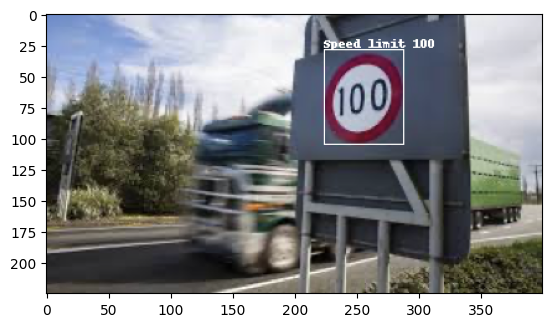

In [5]:
class_name_to_id_mapping = {"Stop": 0,
                            "crosswalk": 1,
                            "Speed limit 40": 2,
                            "Speed limit 80": 3,
                            "Speed limit 100": 4,
                            "No standing": 5,
                            "No entry": 6,
                            "Bicycle Crossing": 7,
                            "Turn right": 8,
                            "No left turn": 9}

# random.seed(100)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotations = [os.path.join("/content/drive/MyDrive/dataset/Speed limit 100", x) for x in os.listdir("/content/drive/MyDrive/dataset/Speed limit 100") if x[-3:] == "txt"]
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# Partition the Dataset

In [6]:
classes = ["Stop", "Crosswalk", "Speed limit 40", "Speed limit 80", "Speed limit 100", "No standing", "No entry", "Bicycle Crossing", "Turn right", "No left turn"]

imagePath = 'data/images'
labelPath = 'data/labels'
trainimagePath = 'data/images/train'
trainlabelPath =  'data/labels/train'
valimagePath = 'data/images/val'
vallabelPath = 'data/labels/val'

if os.path.exists(imagePath):
    shutil.rmtree(imagePath)
if os.path.exists(labelPath):
    shutil.rmtree(labelPath)
if not os.path.exists(imagePath):
    os.mkdir(imagePath)
if not os.path.exists(labelPath):
    os.mkdir(labelPath)
if not os.path.exists(trainimagePath):
    os.mkdir(trainimagePath)
if not os.path.exists(trainlabelPath):
    os.mkdir(trainlabelPath)
if not os.path.exists(valimagePath):
    os.mkdir(valimagePath)
if not os.path.exists(vallabelPath):
    os.mkdir(vallabelPath)

for c in classes:
    path = "/content/drive/MyDrive/dataset/{}".format(c)
    # Read images and annotations
    images = [os.path.join(path, x) for x in os.listdir(path) if x[-3:] == "png"]
    annotations = [os.path.join(path, x) for x in os.listdir(path) if x[-3:] == "txt"]

    images.sort()
    annotations.sort()

    # Split the dataset into train-valid splits
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.15, random_state = 30)


    # Utility function to move images
    def move_files_to_folder(list_of_files, destination_folder):
        for f in list_of_files:
            try:
                shutil.copy2(f, destination_folder)
            except:
                print(f)
                assert False

    # Move the splits into their folders
    move_files_to_folder(train_images, '/content/yolov5/data/images/train')
    move_files_to_folder(val_images, '/content/yolov5/data/images/val/')
    move_files_to_folder(train_annotations, '/content/yolov5/data/labels/train/')
    move_files_to_folder(val_annotations, '/content/yolov5/data/labels/val/')

# Add test pictures

In [7]:
shutil.copytree('/content/drive/MyDrive/test', '/content/yolov5/data/images/test')

'/content/yolov5/data/images/test'

# Data Config File

In [8]:
shutil.copy2('/content/drive/MyDrive/dataset.yaml', '/content/yolov5/data')

'/content/yolov5/data/dataset.yaml'

# Train with pretrained weights

In [9]:
if os.path.exists("runs/train/exp"):
    shutil.rmtree("runs/train/exp")
!python train.py --img 415 --batch 16 --epochs 40 --data dataset.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=415, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

# Inference

In [10]:
image = 'pic6.jpg'
image_path = '/content/yolov5/data/images/test/{}'.format(image)
if os.path.exists("runs/detect/exp"):
    shutil.rmtree("runs/detect/exp")
!python detect.py --source {image_path} --weights /content/yolov5/runs/train/exp/weights/best.pt
image_path = '/content/yolov5/runs/detect/exp/{}'.format(image)
image = Image.open(image_path)
image.show()

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/data/images/test/pic6.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/data/images/test/pic6.jpg: 448x640 1 SL 40, 40.9ms
Speed: 0.5ms pre-process, 40.9ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp
